In [ ]:
from platform import python_version
python_version()

In [2]:
from tensorflow import keras
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from imageio import imread
import cv2
from keras import regularizers
from tensorflow.keras import layers,mixed_precision
from glob import glob 
import pathlib
import argparse
import tensorflow_datasets as tfds

### Analiza wstępna

Inna opcja skalowania 1.

from keras.preprocessing.image import ImageDataGenerator\
train_data = ImageDataGenerator(rescale = 1/255.0)\
valid_data = ImageDataGenerator(rescale = 1/255.0) \
test_data = ImageDataGenerator(rescale = 1/255.0) 

train_generator = train_data.flow_from_directory(trainpath, target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=True)\
validation_generator = valid_data.flow_from_directory(valpath, target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=True)\
test_generator = test_data.flow_from_directory(testpath, target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=True)

Inna opcja skalowania 2.

batch_size = 32 \
image_width = 224 \
image_height = 224 

train_ds = keras.preprocessing.image_dataset_from_directory( \
    trainpath, \
    seed=123, \
    image_size=(image_height, image_width), \
    batch_size=batch_size \
) \

val_ds = keras.preprocessing.image_dataset_from_directory( \
    valpath, \
    seed=123, \
    image_size=(image_height, image_width), \
    batch_size=batch_size \
) \

test_ds = keras.preprocessing.image_dataset_from_directory( \
    testpath, \
    seed=123, \
    image_size=(image_height, image_width), \
    batch_size=batch_size \
)

#### Zmniejszenie liczby obrazów

In [69]:
training_data_path = pathlib.Path(r'C:\Users\SaperX13\Desktop\archive\train')
validatoin_data_path = pathlib.Path(r'C:\Users\SaperX13\Desktop\archive\train')
testing_data_path = pathlib.Path(r'C:\Users\SaperX13\Desktop\archive\train')

#training_data_path = pathlib.Path(r'C:\Users\olga.zieba\Downloads\archive\train')
#validatoin_data_path = pathlib.Path(r'C:\Users\olga.zieba\Downloads\archive\valid')
#testing_data_path = pathlib.Path(r'C:\Users\olga.zieba\Downloads\archive\test')


image_count_train = len(list(training_data_path.glob(r'*/*.jpg')))
image_count_val = len(list(validatoin_data_path.glob(r'*/*.jpg')))
image_count_test = len(list(testing_data_path.glob(r'*/*.jpg')))


all_list_ds = tf.data.Dataset.list_files([str(training_data_path/'*/*'), 
                                         str(validatoin_data_path/'*/*'),
                                         str(testing_data_path/'*/*')], shuffle=False)

all_list_ds = all_list_ds.shuffle(image_count_train, reshuffle_each_iteration=False) #zestaw danych nie jest pseudolosowo tasowany w każdej epoce modelu 

val_size = int(image_count_val * 0.2)
test_size=int(image_count_test * 0.2)      
skip_train = int(image_count_train * 0.6)

train_ds = all_list_ds.take(skip_train)
val_ds = all_list_ds.take(val_size)
test_ds = all_list_ds.take(test_size)

In [70]:
print('Train:', tf.data.experimental.cardinality(train_ds).numpy())
print('Valid:',tf.data.experimental.cardinality(val_ds).numpy())
print('Test:',tf.data.experimental.cardinality(test_ds).numpy())
print('All without reducing:',tf.data.experimental.cardinality(all_list_ds).numpy())

Train: 42375
Valid: 14125
Test: 14125
All without reducing: 211878


In [71]:
class_names = np.array(sorted([item.name for item in training_data_path.glob('*')]))
num_classes = len([item for item in training_data_path.glob('*')])
print("The number of classes is: {}".format(num_classes)) # gatunki

The number of classes is: 450


##### Skalowanie

In [72]:
batch_size = 64
image_width = 224
image_height = 224

In [73]:
def process_path(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    label = tf.argmax(one_hot)
    
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width])
    
    return img, label

In [74]:
train_ds = train_ds.map(process_path,num_parallel_calls=tf.data.AUTOTUNE).batch(64)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE).batch(64)

#### Sprawdzenie czy wszystkie zdjęcia mają jednakową ilość pikseli

In [9]:
def get_counts(dataset_path,dataset_type):

    all_species_count = len(os.listdir(dataset_path))
    all_species_names=[]
    species_image_count=[]
    all_heights=[]
    all_widths=[]
    for i in tqdm(os.listdir(dataset_path)):
        all_species_names.append(i)
        species_folder_path = dataset_path + "/" + i + "/"
        species_image_count.append(len(os.listdir(species_folder_path)))
        for j in os.listdir(species_folder_path):
            filename = species_folder_path + j
            image = imread(filename)
            all_heights.append(image.shape[0])
            all_widths.append(image.shape[1])
    print()
    print(f"Total no. of species in {dataset_type}= {all_species_count}")
    return all_species_names,species_image_count,all_heights,all_widths

In [10]:
trainpath = r'C:\Users\SaperX13\Desktop\archive\train'
testpath = r'C:\Users\SaperX13\Desktop\archive\train'
valpath = r'C:\Users\SaperX13\Desktop\archive\train'

In [11]:
train_species_names,train_species_image_count,train_images_heights,train_images_widths = get_counts(dataset_path=trainpath,dataset_type='train')

100%|███████████████████████████████████████████████████████████████████████████████████| 450/450 [02:17<00:00,  3.27it/s]


Total no. of species in train= 450


Text(0.5, 0, 'Width')

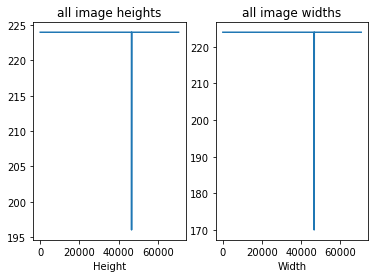

In [12]:
import seaborn as sns

plt.subplot(1,2,1)
sns.lineplot(data=train_images_heights)
plt.title("all image heights")
plt.xlabel("Height")

plt.subplot(1,2,2)
sns.lineplot(data=train_images_widths)
plt.title("all image widths")
plt.xlabel("Width")

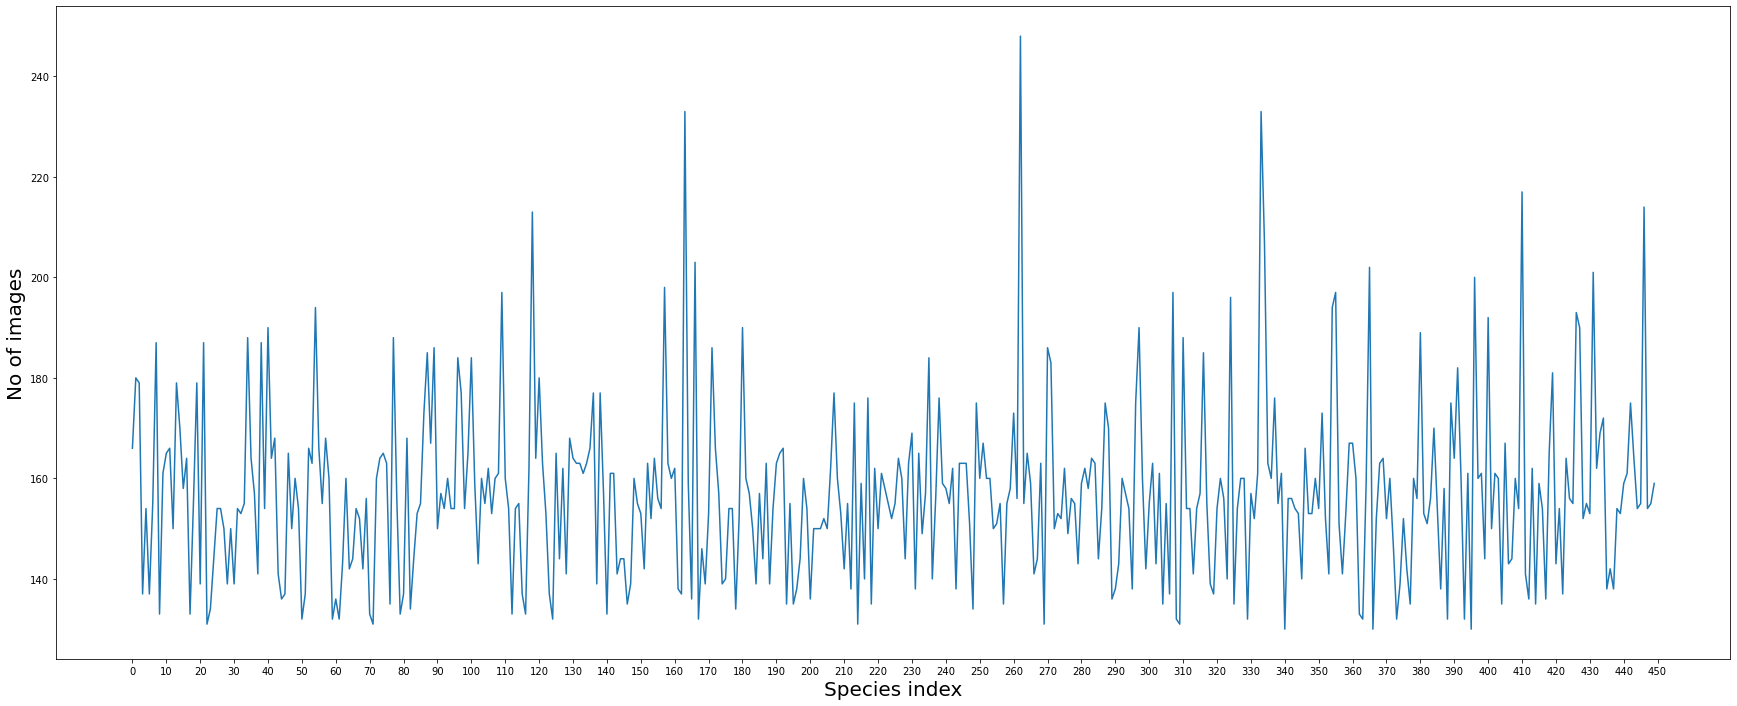

In [13]:
# liczba zdjęć dla każdego gatunku ptaka - wniosek: niezbalansowane dane
plt.figure(figsize=(30,12))
#sns.set(font_scale=1.5)
x = np.random.randint(low=0, high=250, size=450)
plt.xticks(np.arange(0, len(x)+1, 10))

sns.lineplot(data=train_species_image_count)
plt.xlabel("Species index",  fontsize=20)
plt.ylabel("No of images",  fontsize=20);

#### Konfiguracja zbioru danych pod kątem wydajności

Aby wytrenować model z tym zbiorem danych, należy zadbać o to, by dane:

Aby były dobrze potasowane, podzielone na partie jak i by partie były dostępne tak szybko jak to możliwe. Te cechy można dodać za pomocą API tf.data.

#### Wczytanie różnych gatunków ptaków

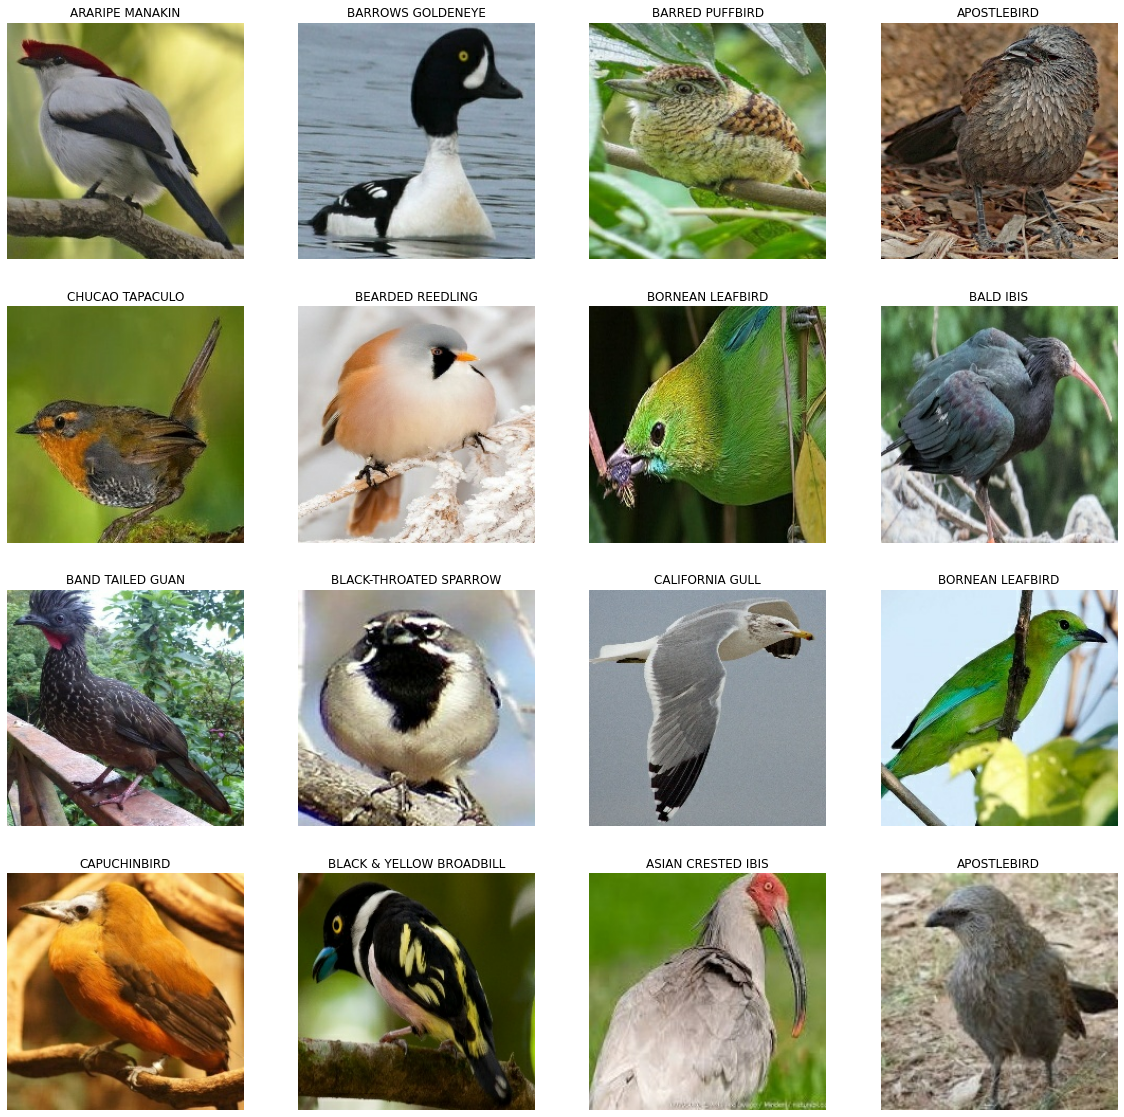

In [14]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(20, 20))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

#### Wczytanie pojedynczego zdjęcia

In [41]:
img_read=cv2.imread(r"C:\Users\SaperX13\Desktop\archive\train\COLLARED ARACARI\014.jpg")
img_read.shape

(224, 224, 3)

In [16]:
img_read2=cv2.imread(r"C:\Users\SaperX13\Desktop\archive\train\CRAB PLOVER\013.jpg")

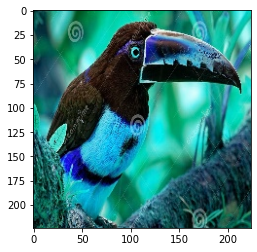

In [17]:
plt.imshow(img_read)
plt.show()

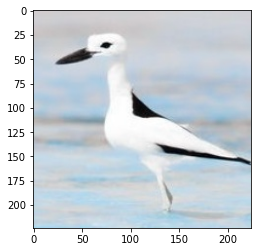

In [18]:
plt.imshow(img_read2);

#### Wczytanie bazy 1

In [19]:
birds_data = pd.read_csv(r"C:\Users\SaperX13\Desktop\archive\birds.csv")
birds_data.head()

class id                      filepaths           labels  \
0         0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER   
1         0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER   
2         0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER   
3         0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER   
4         0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER   

       scientific label data set  
0  Malacocincla abbotti    train  
1  Malacocincla abbotti    train  
2  Malacocincla abbotti    train  
3  Malacocincla abbotti    train  
4  Malacocincla abbotti    train

In [20]:
#Unikalne gatunki ptaków
birds_species = np.unique(birds_data.labels)
len(birds_species)

450

#### Wczytanie kilku zdjęć jednego gatunku 

In [21]:
boolean_labels = []
for i in range(len(birds_data)):
    boolean_labels.append(birds_data.labels[i] == birds_species)

labels = birds_data.labels

In [22]:
filepaths = []

for i in range(len(birds_data)):
    filepath = r"C:\Users\\SaperX13\\Desktop\\archive\\" + str(birds_data.filepaths[i])
    filepaths.append(filepath)

In [23]:
def plot_image(filepaths, start=0, end=12):
    plt.figure(figsize=(20,30))
    rows = (end - start)//2
    cols = (end-start) - ((end - start)//2)
    
    for i in range(start, start + (end - start)):
        ax = plt.subplot(rows, cols, i+1-start)
        image = plt.imread(filepaths[i])
        plt.imshow(image)
        plt.title(birds_species[boolean_labels[i].argmax()])
        plt.axis("off")

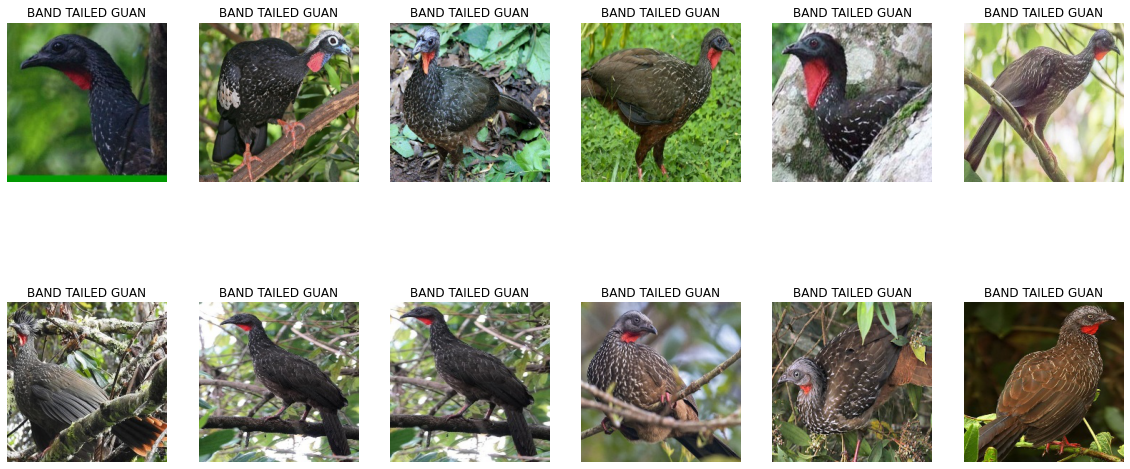

In [24]:
plot_image(filepaths, start=8400, end=8412)

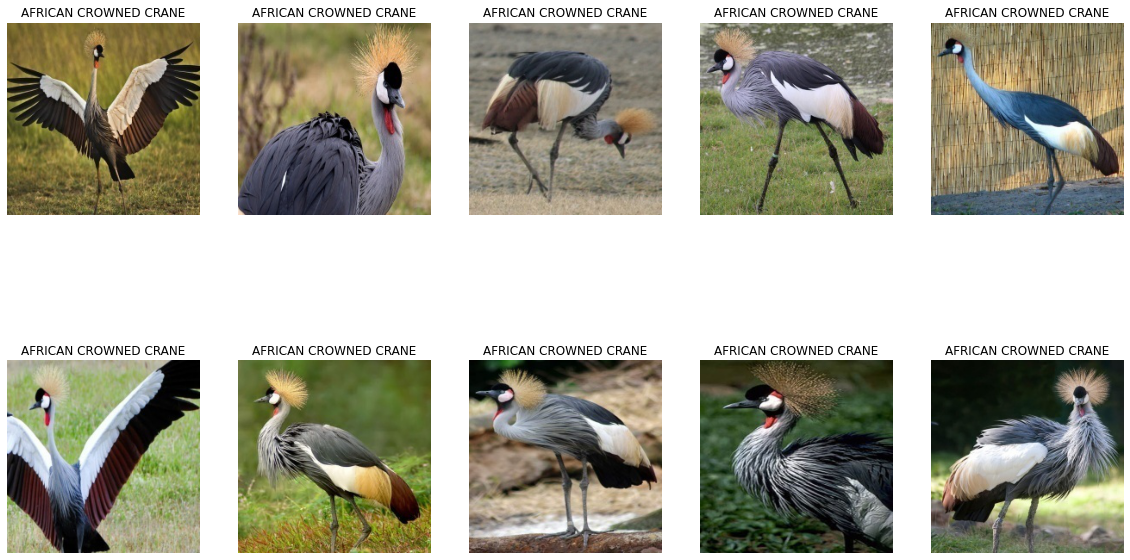

In [25]:
plot_image(filepaths, start=526, end=536)

#### Budowa modelu

###### model 1

In [26]:
model = keras.Sequential([ 
    layers.InputLayer((224, 224, 3)),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Regularyzacja
    layers.Dense(
        units=64,
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        bias_regularizer=regularizers.L2(1e-4),
        activity_regularizer=regularizers.L2(1e-5)
    ),

    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(450, activation='softmax')
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      21        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     448       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                        

In [28]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=False),
    #loss='categorical_crossentropy',
                   
    metrics=['accuracy']
)

In [29]:

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=20, 
    #shuffle=True,
    verbose=1
)

Epoch 1/20
663/663 [==============================] - 259s 335ms/step - loss: 5.4419 - accuracy: 0.0313 - val_loss: 4.4758 - val_accuracy: 0.0680
Epoch 2/20
663/663 [==============================] - 218s 329ms/step - loss: 3.5527 - accuracy: 0.1868 - val_loss: 3.3152 - val_accuracy: 0.2213
Epoch 3/20
663/663 [==============================] - 216s 326ms/step - loss: 2.7185 - accuracy: 0.3338 - val_loss: 2.6969 - val_accuracy: 0.3353
Epoch 4/20
663/663 [==============================] - 216s 326ms/step - loss: 2.0837 - accuracy: 0.4687 - val_loss: 2.2116 - val_accuracy: 0.4321
Epoch 5/20
663/663 [==============================] - 219s 330ms/step - loss: 1.5457 - accuracy: 0.5994 - val_loss: 1.8854 - val_accuracy: 0.4838
Epoch 6/20
663/663 [==============================] - 216s 326ms/step - loss: 1.1698 - accuracy: 0.6892 - val_loss: 1.4275 - val_accuracy: 0.6033
Epoch 7/20
663/663 [==============================] - 216s 326ms/step - loss: 0.8804 - accuracy: 0.7648 - val_loss: 1.3189 -

##### zapis i załadowanie modelu

In [33]:
from tensorflow.keras.models import save_model
save_model(model, "model.h5")

In [34]:
from tensorflow.keras.models import load_model
 
model = load_model('model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      21        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     448       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                        

##### Ocena modelu

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
print("Validation:",np.array(history.history['val_accuracy']).max())
print("Train:",np.array(history.history['accuracy']).max())

Validation: 0.8933805227279663
Train: 0.9565545916557312


In [31]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    #plot loss
    fig=plt.figure(figsize=(15,6))
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    fig=plt.figure(figsize=(15,6))
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    plt.tight_layout()

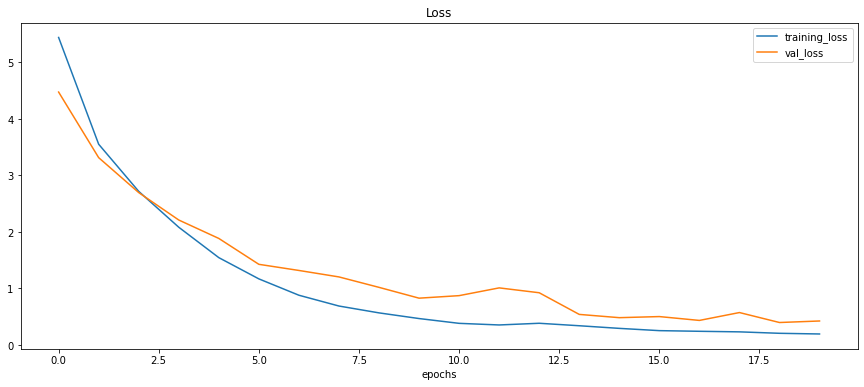

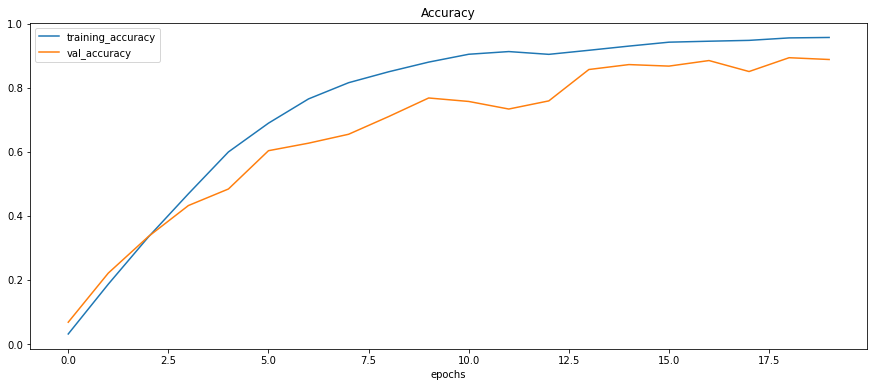

<Figure size 432x288 with 0 Axes>

In [32]:
plot_curves(history)

##### predykcja

In [75]:
def load_and_prep_image(filename, img_shape = 224):
    img = tf.io.read_file(filename) 
    img = tf.image.decode_image(img) 
    img = tf.image.resize(img, size = [img_shape, img_shape]) 
    img = img/255. 
    return img

In [76]:
def pred_and_plot(model, filename, class_names):

    img = load_and_prep_image(filename)

    pred = model.predict(tf.expand_dims(img, axis=0))
    
    if len(pred[0]) > 1: 
        pred_class = class_names[pred.argmax()] 
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] 

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

1/1 [==============================] - 0s 29ms/step


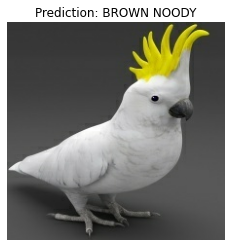

In [77]:
pred_and_plot(model, r'C:\Users\SaperX13\Desktop\archive\test\COCKATOO\1.jpg', class_names)

1/1 [==============================] - 0s 27ms/step


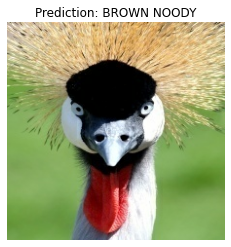

In [83]:
pred_and_plot(model, r'C:\Users\SaperX13\Desktop\archive\test\AFRICAN CROWNED CRANE\2.jpg', class_names)